In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prototxt_url = 'colorization_deploy_v2.prototxt'
caffemodel_url = 'colorization_release_v2.caffemodel'
pts_in_hull_url = 'pts_in_hull.npy'

In [3]:

import os
import urllib.request

In [4]:
if not os.path.exists('colorization_deploy_v2.prototxt'):
    urllib.request.urlretrieve(prototxt_url, 'colorization_deploy_v2.prototxt')
if not os.path.exists('colorization_release_v2.caffemodel'):
    urllib.request.urlretrieve(caffemodel_url, 'colorization_release_v2.caffemodel')
if not os.path.exists('pts_in_hull.npy'):
    urllib.request.urlretrieve(pts_in_hull_url, 'pts_in_hull.npy')

In [5]:
net = cv2.dnn.readNetFromCaffe('colorization_deploy_v2.prototxt', 'colorization_release_v2.caffemodel')

In [6]:
pts_in_hull = np.load('pts_in_hull.npy') 

In [7]:
class8 = net.getLayerId('class8_ab')
conv8 = net.getLayerId('conv8_313_rh')
pts = pts_in_hull.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype(np.float32)]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

In [8]:
img_path = 'images.jpg'  # <-- your black & white image here
frame = cv2.imread(img_path)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # make sure it is grayscale
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

In [9]:
W_in = 224
H_in = 224
img_rgb = (frame[:, :, [2, 1, 0]] / 255.).astype(np.float32)

In [10]:
img_rs = cv2.resize(img_rgb, (W_in, H_in))  # resize image to network input size
img_lab = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
img_l = img_lab[:, :, 0]

In [11]:
net.setInput(cv2.dnn.blobFromImage(img_l))
ab_dec = net.forward()[0, :, :, :].transpose((1, 2, 0))

In [12]:
(H_orig, W_orig) = img_rgb.shape[:2]
ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
img_l_orig = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)[:, :, 0]
img_lab_out = np.concatenate((img_l_orig[:, :, np.newaxis], ab_dec_us), axis=2)
img_bgr_out = cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR)
img_bgr_out = np.clip(img_bgr_out, 0, 1)

(-0.5, 194.5, 182.5, -0.5)

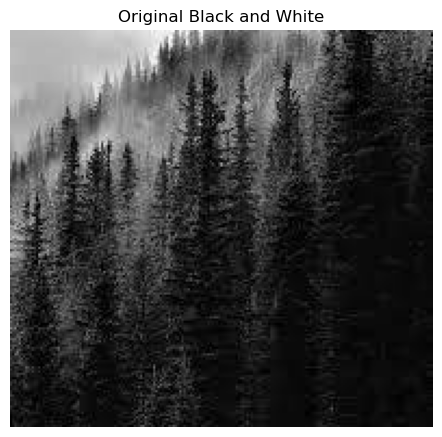

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Black and White')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')

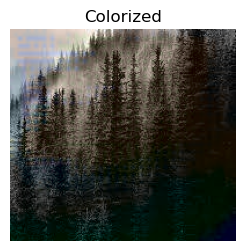

In [14]:
plt.subplot(1, 2, 2)
plt.title('Colorized')
plt.imshow(img_bgr_out)
plt.axis('off')
plt.show()